In [15]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import medfilt
import re

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
plt.rc('font', family='Arial')
global_medfilt_kernel_size = 31

In [3]:
data = pd.DataFrame(pd.read_pickle('data\sensor_13050091.pkl'))

In [4]:
data.isna().sum()

edge                              0
date                              0
Now_PowerFactor_Phase_2_value    16
Now_Power_S_Phase_3_value        16
Now_Power_Q_Phase_1_value        16
Now_Current_Phase_3_value        16
Now_PowerFactor_Phase_3_value    16
Now_Power_S_Phase_2_value        16
Now_Angle_Ph_2vs3_value          16
Now_Voltage_Phase_2_value        16
Now_Power_P_Phase_1_value        16
Now_Power_Q_Phase_3_value        16
Now_Angle_Ph_1vs3_value          16
Now_Voltage_Phase_1_value        16
Now_Power_S_Phase_1_value        16
Now_Power_P_Phase_3_value        16
Now_Power_Q_Phase_2_value        16
Now_Current_Phase_1_value        16
Now_Angle_Ph_1vs2_value          16
Now_PowerFactor_Phase_1_value    16
Now_Power_P_Phase_2_value        16
Now_Voltage_Phase_3_value        16
Now_Current_Phase_2_value        16
dtype: int64

In [5]:
# fill NaN values
data.fillna(method='bfill', inplace=True)

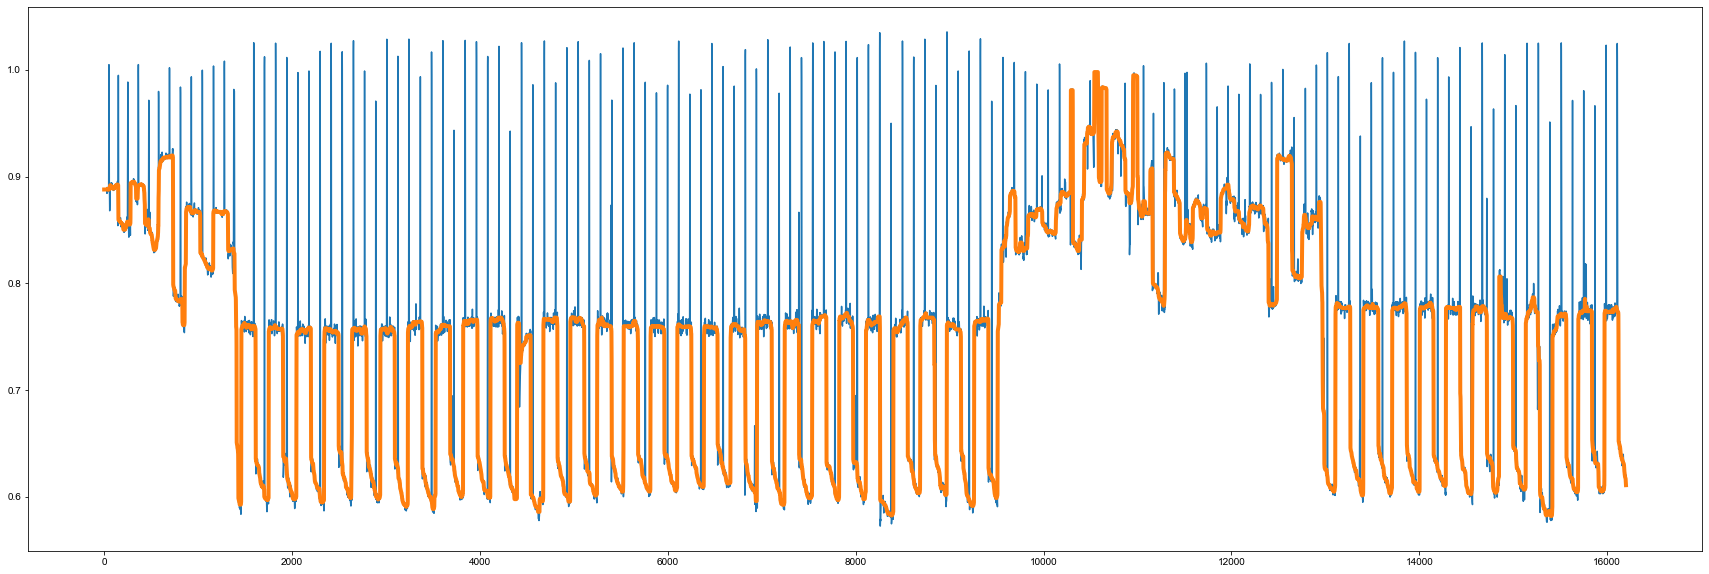

In [6]:
plt.figure(figsize=(30,10))
plt.plot(data[data.columns[6]])
plt.plot(medfilt(data[data.columns[6]], global_medfilt_kernel_size), linewidth=4)

In [7]:
# Divides a time series into "words" of adaptive length
def get_sequence(data_series, 
                 word_length_similarity_threshold, 
                 word_length_significance_threshold, 
                 steps = 30,
                 medfilt_kernel_size = 31):
    #perform median filter 
    data = medfilt(data_series.to_numpy(), medfilt_kernel_size) 
    word_mean_similarity_threshold = (data.max() - data.min()) / steps 
    noise_threshold = word_mean_similarity_threshold / 2
    result = {} 
    result['words'] = []
    ascii_num = 49
    word_idx = 0
    prev_value = data[0]
    new_word = None
    new_word_values = [prev_value]
    for value in data[1:]:
        # if next value is different by more than noise_threshold, interrupt word
        if abs(value - prev_value) > noise_threshold:
            mean = np.mean(new_word_values)
            length = len(new_word_values)
            # decide whether a new word is similar to any of the words that already occurred, starting from the beginning 
            # word_length_similarity_threshold 3
            # means that the words can have the same name if their lengths differ by no less than 30%
            try: 
                name = next(word for word in result['words'] if (abs(word['mean'] - mean) < word_mean_similarity_threshold) 
                            and abs(1 - (length/word['length'])) < word_length_similarity_threshold)['name']
            # if no similar words found, get new name
            except StopIteration:
                name = chr(ascii_num)
                ascii_num += 1
                
            below_len_threshold = length < word_length_significance_threshold 
            new_word = {'length': length, 'mean': mean, 'name': name,  
                        'below_len_threshold': below_len_threshold, 'idx': word_idx if not below_len_threshold else -1}
            
            if not below_len_threshold: 
                word_idx += 1
            
            result['words'].append(new_word)
            new_word_values = [value]
        else: 
            new_word_values.append(value)
        prev_value = value
        
    result['words'].append(new_word)
    result['string'] = ''.join([word['name'] for word in result['words'] if not word['below_len_threshold']])
    result['full_string'] = ''.join([word['name'] for word in result['words']])
    return result

In [8]:
# creates pandas DataFrame for visualization purposes
def sequence_to_DataFrame(sequence):
    unravel = []
    for word in sequence['words']:
        for idx in range(word['length']):
            record = {}
            for key in word.keys():
                record[key] = word[key]
            unravel.append(record)
    result = pd.DataFrame(unravel)
    return result

In [9]:
def get_all_patterns(substring, string):
    tuples = [m.span() for m in re.finditer('(' + re.escape(substring) + ')', string)]
    result = [] 
    temp = tuples[0]
    for idx, tup in enumerate(tuples[1:]):
        if overlap(tup, temp):
            temp = join_overlap(tup, temp)
        else:
            if (temp[1] - temp[0]) != len(substring):
                temp = (temp[0], temp[1]-1)
                result.append(temp)
            temp = tup
    if (temp[1] - temp[0]) != len(substring):
        temp = (temp[0], temp[1]-1)
        result.append(temp)
    return result

In [10]:
# brute-force search for patterns in the string
def find_uninterrupted_patterns(string, length=2):
    result = {}
    substrings=[]
    max_length = len(string) - 1
    # string = sequence['string'] 
    for sublen in range(2, length+1):
        for idx in range(0,len(string)-sublen):
            sub = string[idx:idx+sublen]
            if sub not in substrings:
                substrings.append(sub)
    
    for substring in substrings:
        result[substring] = get_all_patterns(substring, string)
    
    return result

def get_word_indices(df, word_num):
    return (df[df['idx'] == word_num].iloc[0].name, df[df['idx'] == word_num].iloc[-1].name)

def overlap(tuple1, tuple2):
    return (tuple1[1] >= tuple2[0] and tuple1[0] <= tuple2[1])

def join_overlap(tuple1, tuple2):
    return (tuple1[0] if tuple1[0] < tuple2[0] else tuple2[0], tuple1[1] if tuple1[1] > tuple2[1] else tuple2[1]) 

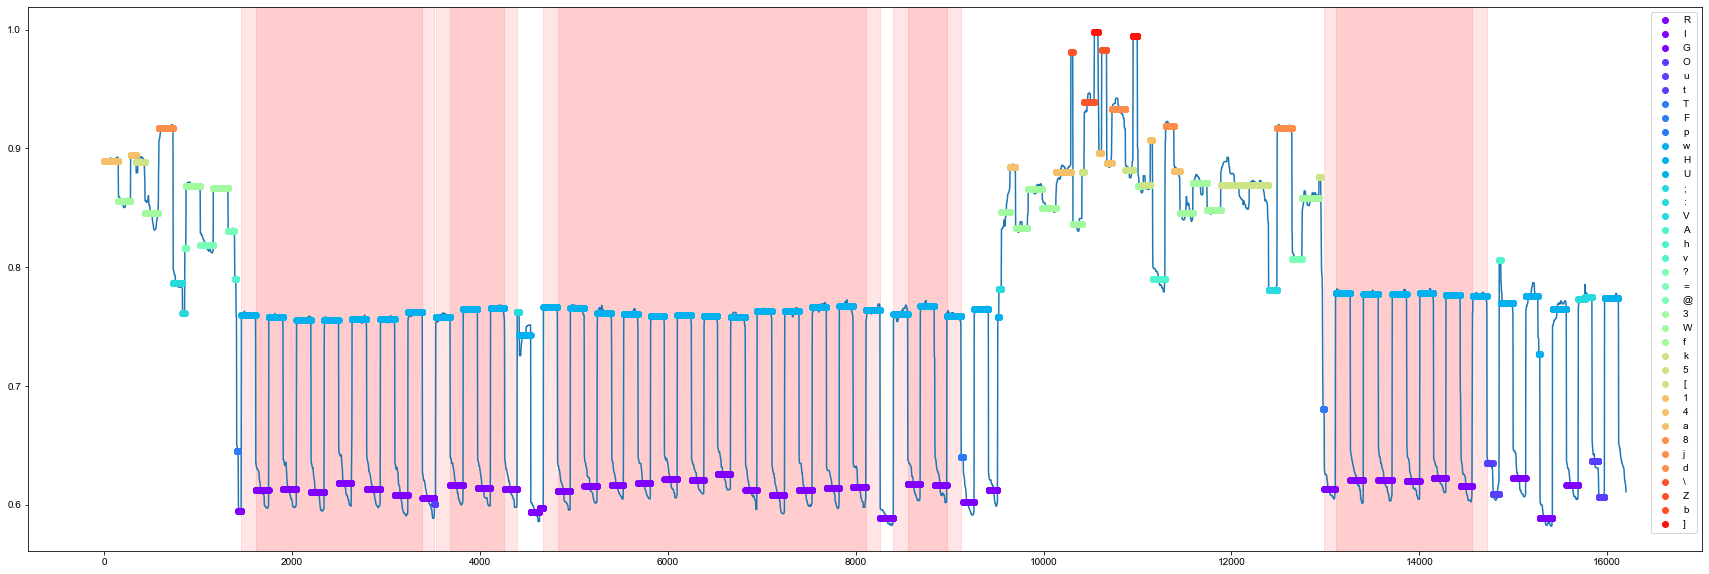

In [11]:
sequence = get_sequence(data[data.columns[6]], 0.3, 10)
df = sequence_to_DataFrame(sequence)

plt.figure(figsize=(30,10))

cm = plt.get_cmap('rainbow')
plt.plot(medfilt(data[data.columns[6]], 31))
words = df[~df['below_len_threshold']].sort_values(by='mean')
word_types_cnt = len(words['name'].unique())

for idx, word_type in enumerate(words['name'].unique()):
    line = plt.plot(words[words['name'] == word_type]['mean'], 'o', label = word_type)
    line[0].set_color(cm(idx//3*3.0/word_types_cnt))
    
patterns = find_uninterrupted_patterns(sequence['string'], 2)
for pattern in patterns.values(): 
    for value in pattern:
        plt.axvspan(get_word_indices(df, value[0])[0], get_word_indices(df, value[1])[1], color='red', alpha=0.1)

        
plt.legend()
plt.show()

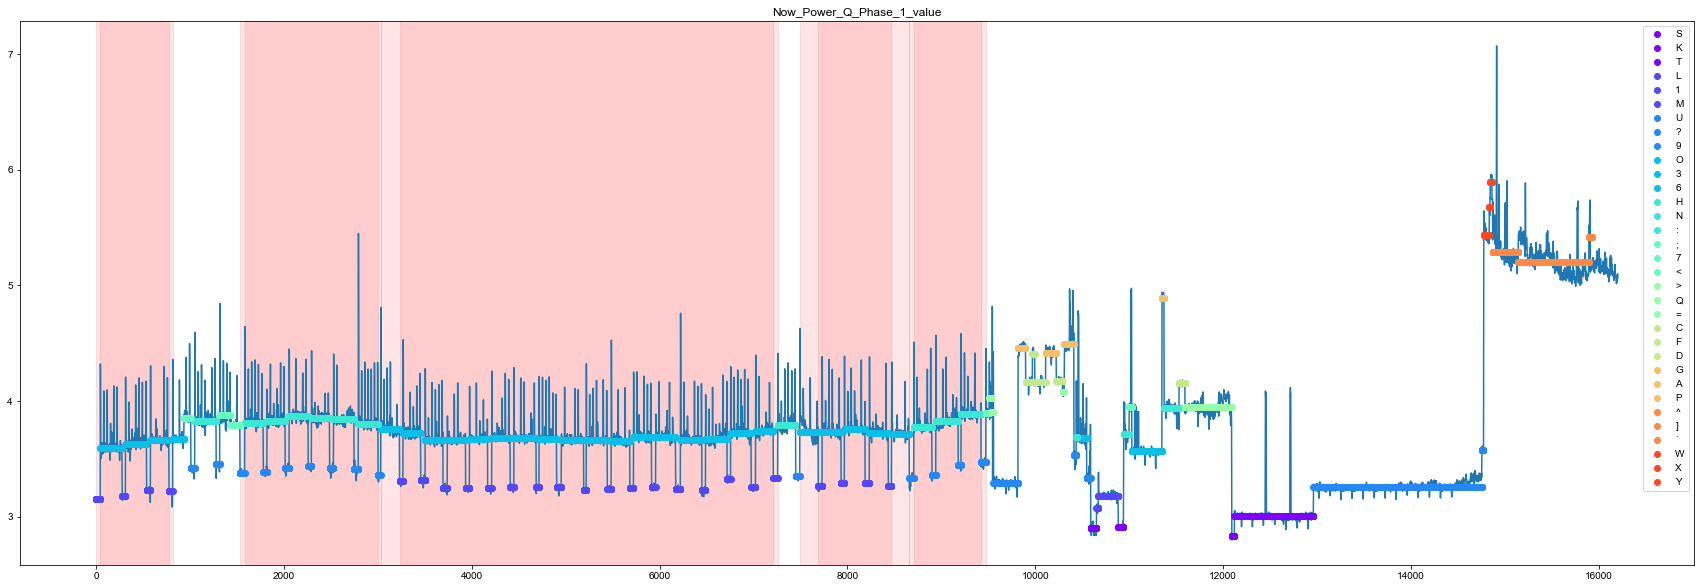

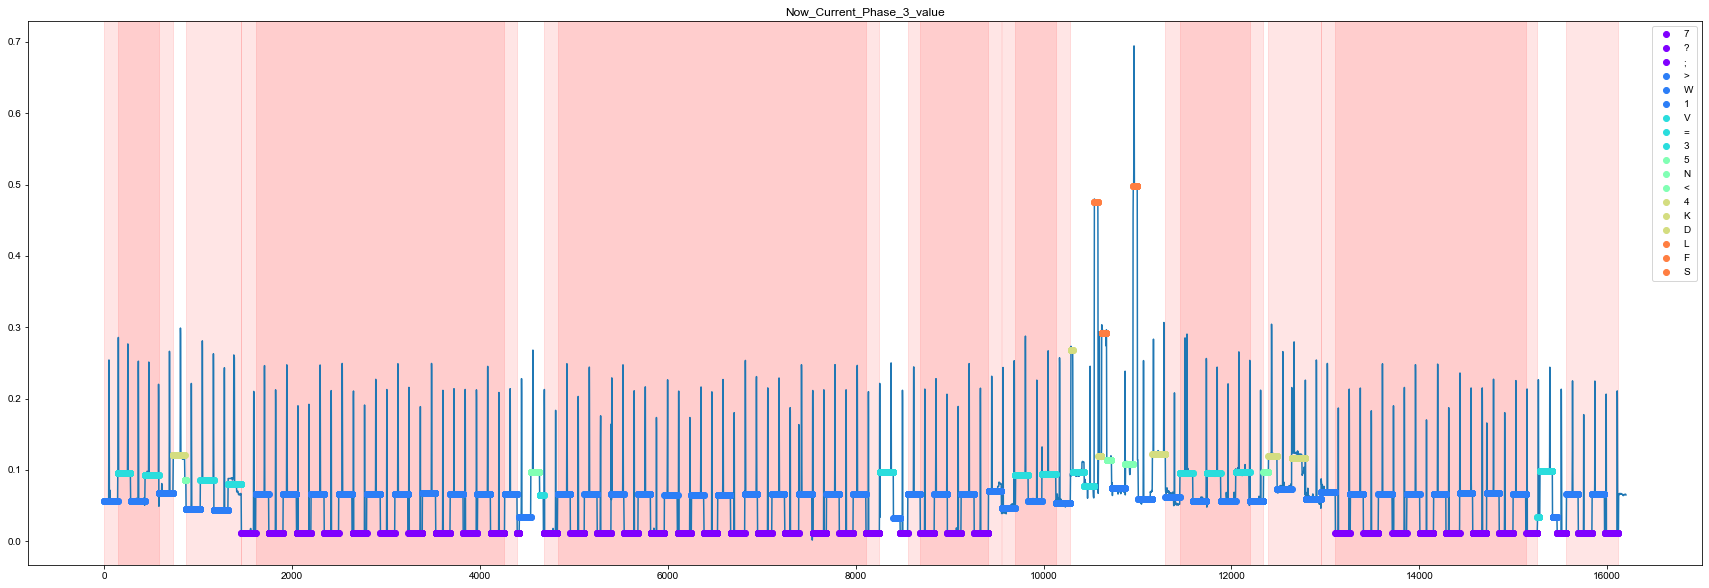

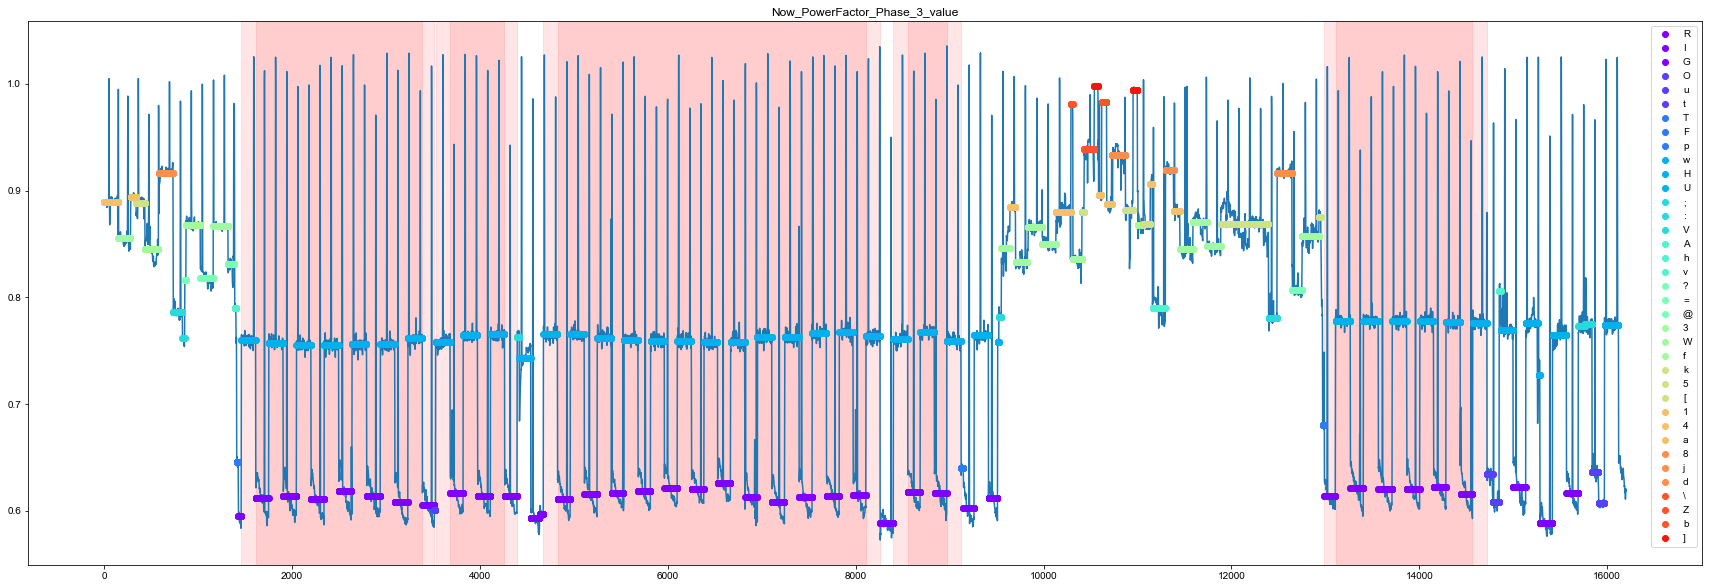

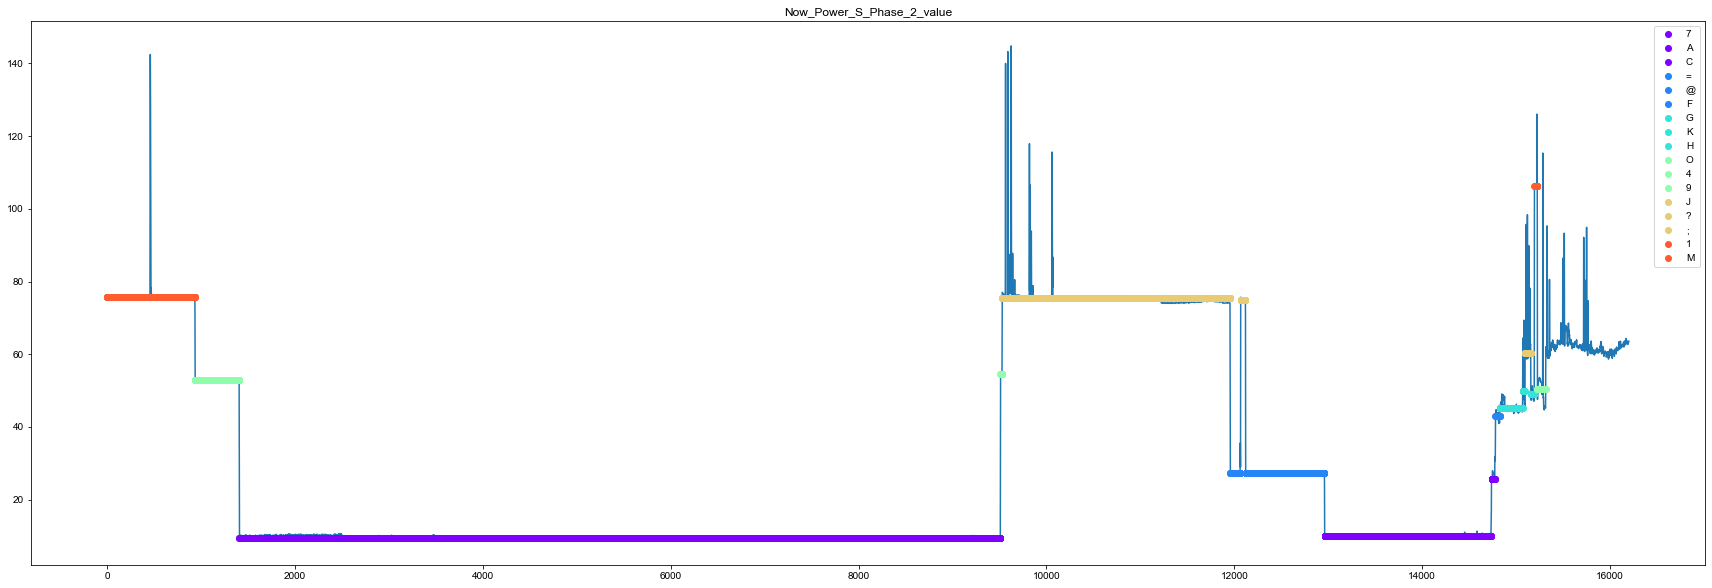

In [22]:
for col_idx, column in enumerate(data.columns[4:8]):
    if (str(data[column].dtype) != 'object'):
        sequence = get_sequence(data[column], 0.3, 10)
        df = sequence_to_DataFrame(sequence)
        plt.figure(figsize=(30,10))
        plt.plot(data[column])
        cm = plt.get_cmap('rainbow')

        words = df[~df['below_len_threshold']].sort_values(by='mean')
        word_types_cnt = len(words['name'].unique())

        for idx, word_type in enumerate(words['name'].unique()):
            line = plt.plot(words[words['name'] == word_type]['mean'], 'o', label = word_type)
            line[0].set_color(cm(idx//3*3.0/word_types_cnt))
            
        patterns = find_uninterrupted_patterns(sequence['string'], 2)
        for pattern in patterns.values(): 
            for value in pattern:
                plt.axvspan(get_word_indices(df, value[0])[0], get_word_indices(df, value[1])[1], color='red', alpha=0.1)

        plt.title(column)
        plt.legend()
        plt.show()